In [1]:
import numpy as np 
import pandas as pd 
from numpy import array
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset,DataLoader

In [10]:
df = pd.read_csv('../input/tehran-stock-price/output.csv').rename(columns={'Unnamed: 0':'timestamp'}).set_index('date')
df=df[["close"]]

In [11]:
test_set_size = int(np.round(0.2*df.shape[0]));
train_set_size = df.shape[0] - (test_set_size); 
train_set =df[:train_set_size]
valid_set = df[train_set_size:]
print('Proportion of train_set : {:.2f}%'.format(len(train_set)/len(df)))
print('Proportion of valid_set : {:.2f}%'.format(len(valid_set)/len(df)))

Proportion of train_set : 0.80%
Proportion of valid_set : 0.20%


In [12]:
def split_sequence(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        
        end_ix = i + n_steps
        
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return array(x), array(y)
n_steps = 20
train_x,train_y = split_sequence(train_set["close"],n_steps)
valid_x,valid_y = split_sequence(valid_set["close"],n_steps)

In [20]:
train_x[1],train_y[1]

(array([12600., 13230., 13891., 14585., 15314., 15429., 15198., 15187.,
        14785., 14345., 13772., 13717., 13380., 13363., 13284., 13253.,
        13185., 12757., 12647., 12492.]), 12433.0)

### Build CNN Forecast Model

In [13]:
class StockDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item,label

In [25]:
class CNN_ForecastNet(nn.Module):
    def __init__(self):
        super(CNN_ForecastNet,self).__init__()
        self.conv1d = nn.Conv1d(20,128,kernel_size=2,padding=2)
        self.relu = nn.ReLU(inplace=True)
        self.conv1d2 = nn.Conv1d(128,256,kernel_size=2)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool=nn.MaxPool1d(2)
        self.flatten=nn.Flatten()
        self.dense1=nn.Linear(256,50)
        self.dense2=nn.Linear(50,1)
    def forward(self,x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = self.conv1d2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dense2(x)
        return x

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN_ForecastNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [27]:
print(model)

CNN_ForecastNet(
  (conv1d): Conv1d(20, 128, kernel_size=(2,), stride=(1,), padding=(2,))
  (relu): ReLU(inplace=True)
  (conv1d2): Conv1d(128, 256, kernel_size=(2,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (dense1): Linear(in_features=256, out_features=50, bias=True)
  (dense2): Linear(in_features=50, out_features=1, bias=True)
)


#### Do I have to think autocorrelation when setting batch_size? 
Maybe Batch_size is important, and It is related with autocorrelation I guess.

In [28]:
train = StockDataset(train_x.reshape(train_x.shape[0],train_x.shape[1],1),train_y)
valid =  StockDataset(valid_x.reshape(valid_x.shape[0],valid_x.shape[1],1),valid_y)
train_loader = torch.utils.data.DataLoader(train,batch_size=32,shuffle=False)
valid_loader = torch.utils.data.DataLoader(train,batch_size=32,shuffle=False)

In [47]:
train_x.shape[0],train_x.shape[1],1

(2675, 5, 1)

In [11]:
valid_x.shape[0],valid_x.shape[1],1

(665, 5, 1)

In [29]:
train_losses = []
valid_losses = []
def Train():
    
    running_loss = .0
    
    model.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(inputs.float())
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss**(0.5)
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().numpy())
    
    print(f'train_loss {train_loss}')
    return train_loss
    
def Valid():
    running_loss = .0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            #optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            running_loss += loss**(0.5)
            
        valid_loss = running_loss/len(valid_loader)
        valid_losses.append(valid_loss.detach().numpy())
        print(f'valid_loss {valid_loss}')

In [32]:
epochs = 100
for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    Train()
    Valid()
    gc.collect()

epochs 1/100
train_loss 1085.6732177734375
valid_loss 1084.7623291015625
epochs 2/100
train_loss 1083.33935546875
valid_loss 1082.554931640625
epochs 3/100
train_loss 1081.192626953125
valid_loss 1080.5001220703125
epochs 4/100
train_loss 1079.1810302734375
valid_loss 1078.5052490234375
epochs 5/100
train_loss 1077.195068359375
valid_loss 1076.6943359375
epochs 6/100
train_loss 1075.2685546875
valid_loss 1074.5638427734375
epochs 7/100
train_loss 1073.188232421875
valid_loss 1072.4559326171875
epochs 8/100
train_loss 1071.0242919921875
valid_loss 1070.442626953125
epochs 9/100
train_loss 1069.047607421875
valid_loss 1068.50244140625
epochs 10/100
train_loss 1067.0804443359375
valid_loss 1066.4615478515625
epochs 11/100
train_loss 1065.203369140625
valid_loss 1064.880615234375
epochs 12/100
train_loss 1063.560791015625
valid_loss 1062.9775390625
epochs 13/100
train_loss 1061.5936279296875
valid_loss 1061.1019287109375
epochs 14/100
train_loss 1059.6973876953125
valid_loss 1059.181762695

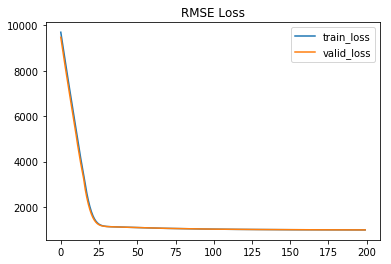

In [206]:
import matplotlib.pyplot as plt
plt.plot(train_losses,label='train_loss')
plt.plot(valid_losses,label='valid_loss')
plt.title('RMSE Loss')
plt.legend()

In [207]:
target_x , target_y = split_sequence(valid_set["close"],n_steps)
inputs = target_x.reshape(target_x.shape[0],target_x.shape[1],1)

In [208]:
model.eval()
prediction = []
batch_size = 1
iterations =  inputs.shape[0]

for i in range(iterations):
    preds = model(torch.tensor(inputs[batch_size*i:batch_size*(i+1)]).float())
    prediction.append(preds[0,0].detach().numpy())

#### Prediction Result

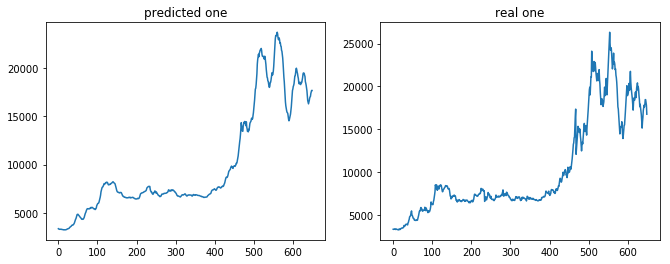

In [209]:
fig, ax = plt.subplots(1, 2,figsize=(11,4))
ax[0].set_title('predicted one')
ax[0].plot(prediction)
ax[1].set_title('real one')
ax[1].plot(target_y)
plt.show()

Text(0, 0.5, 'Close Price')

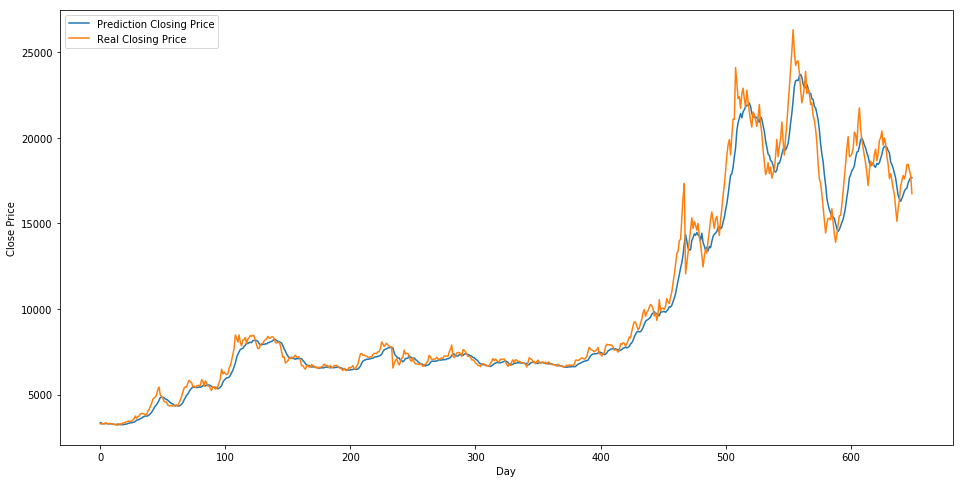

In [210]:

plt.figure(figsize=(16,8))
plt.plot(prediction[:],label='Prediction Closing Price')
plt.plot(target_y,label='Real Closing Price')
plt.legend()
plt.xlabel("Day")
plt.ylabel("Close Price")

In [ ]:
import torch.optim as optim

In [ ]:
def objective(trial):
    network = CNN_ForecastNet(trial)
    print(network)
    optimizer= optim.SGD(network.parameters(),
    lr=trial.suggest_loguniform('learning_rate', 1e-5, 1e-2))
    final_loss=Train()
    return(final_loss)

In [ ]:
#!pip install optuna

In [ ]:
import optuna
study_name = 'example-study2'  # Unique identifier of the study.
study = optuna.create_study(study_name=study_name, storage='sqlite:///example.db')
study.optimize(objective, n_trials=2)

In [ ]:
study = optuna.create_study(study_name='example-study2', storage='sqlite:///example.db', load_if_exists=True)
df = study.trials_dataframe()

In [ ]:
df

In [ ]:
print(study.best_params)  # Get best parameters for the objective function.
print('_____________________')
print(study.best_value)  # Get best objective value.
print('_____________________')
print(study.best_trial)  # Get best trial's information.
print('_____________________')
print(study.trials) # Get all trials' information.